# Visualize PV curves from segment `.npz` files
This notebook mirrors *Visualize-PVcurve.ipynb* but reads the processed sensor segments stored as `.npz` under `data/MMDataset_segments`. Configure the segment path, optionally list available files, and the notebook will load flow/pressure traces, integrate flow to obtain volume (with baseline drift correction), and draw the PV curve.

In [ ]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams['figure.dpi'] = 120


In [ ]:

def list_npz_files(segments_root: str, max_show: int = 5):
    pattern = os.path.join(segments_root, "**", "*.npz")
    files = sorted(glob.glob(pattern, recursive=True))
    print(f"Found {len(files)} segment files.")
    for i, f in enumerate(files[:max_show]):
        print(f"[{i}] {f}")
    if len(files) > max_show:
        print("... (and more)")
    return files


def _resolve_column(df: pd.DataFrame, hint: str, description: str) -> str:
    """Return the column name that matches hint exactly or by prefix (case-insensitive)."""
    if not hint:
        raise ValueError(f"No {description} hint provided.")
    if hint in df.columns:
        return hint
    candidates = [c for c in df.columns if c.startswith(hint)]
    if not candidates:
        candidates = [c for c in df.columns if c.lower().startswith(hint.lower())]
    if not candidates:
        available = ', '.join(df.columns[:10])
        raise ValueError(f"Could not find {description} matching '{hint}'. Available columns (first 10): {available}")
    if len(candidates) > 1:
        candidates.sort(key=len, reverse=True)
    return candidates[0]


def _scalar_value(arr):
    if np.ndim(arr) == 0:
        return arr.item()
    return arr


def load_npz_segment(
    npz_path: str,
    flow_col: str,
    press_col: str,
    time_col: str = "sensor_time_epoch"
) -> tuple[pd.DataFrame, str, str, str, dict]:
    data = np.load(npz_path, allow_pickle=True)
    sensor_cols = [str(c) for c in data["sensor_cols"]]
    sensor_values = data["sensor_values"]
    df = pd.DataFrame(sensor_values, columns=sensor_cols)
    if time_col not in data:
        raise ValueError(f"'{time_col}' not found in npz (available keys: {data.files})")
    time_values = data[time_col].astype(float)
    df = df.copy()
    df.insert(0, time_col, time_values)

    time_name = _resolve_column(df, time_col, "time column")
    flow_name = _resolve_column(df, flow_col, "flow column")
    press_name = _resolve_column(df, press_col, "pressure column")

    meta = {
        "label": str(_scalar_value(data.get("label", ""))),
        "sensor_id": str(_scalar_value(data.get("sensor_id", ""))),
        "audio_id": str(_scalar_value(data.get("audio_id", ""))),
        "audio_start_utc": float(_scalar_value(data.get("audio_start_utc", 0.0))),
        "audio_end_utc": float(_scalar_value(data.get("audio_end_utc", 0.0))),
    }
    return df, flow_name, press_name, time_name, meta


def select_sensor_window(
    df: pd.DataFrame,
    time_col: str = "sensor_time_epoch",
    start_utc: float | None = None,
    duration_sec: float | None = None,
    start_index: int | None = None,
    num_samples: int | None = None,
) -> pd.DataFrame:
    window = df
    if start_utc is not None and duration_sec is not None:
        end_utc = start_utc + duration_sec
        mask = (df[time_col] >= start_utc) & (df[time_col] <= end_utc)
        window = df.loc[mask]
    elif start_index is not None:
        end_idx = start_index + num_samples if num_samples is not None else None
        window = df.iloc[start_index:end_idx]
    return window.reset_index(drop=True)


def compute_volume_from_flow(
    df: pd.DataFrame,
    flow_col: str,
    time_col: str
) -> tuple[np.ndarray, np.ndarray]:
    """Integrate flow to get volume (litres) and remove slow baseline drift."""
    time_s = df[time_col].to_numpy(dtype=float)
    time_rel = time_s - time_s[0]
    flow_slm = df[flow_col].to_numpy(dtype=float)
    flow_lps = flow_slm / 60.0
    dt = np.diff(time_rel, prepend=0.0)
    volume_l = np.cumsum(flow_lps * dt)
    volume_l -= volume_l[0]

    if len(volume_l) > 1:
        slope, intercept = np.polyfit(time_rel, volume_l, 1)
        drift = slope * time_rel + intercept
        volume_l = volume_l - drift
        volume_l -= volume_l[0]

    return time_rel, volume_l


def plot_flow_and_pressure(
    df: pd.DataFrame,
    time_rel: np.ndarray,
    flow_col: str,
    press_col: str
) -> None:
    fig, ax_flow = plt.subplots(figsize=(10, 4))
    ln1 = ax_flow.plot(time_rel, df[flow_col], color="tab:blue", label="Flow (slm)")
    ax_flow.axhline(0.0, color="tab:blue", linestyle="--", linewidth=0.5)
    ax_flow.set_xlabel("Time (s)")
    ax_flow.set_ylabel("Flow (slm)", color="tab:blue")

    ax_press = ax_flow.twinx()
    ln2 = ax_press.plot(time_rel, df[press_col], color="tab:orange", linestyle="--", label="Pressure (Pa)")
    ax_press.axhline(0.0, color="tab:orange", linestyle=":", linewidth=0.5)
    ax_press.set_ylabel("Pressure (Pa)")

    lines = ln1 + ln2
    labels = [l.get_label() for l in lines]
    ax_flow.legend(lines, labels, loc="best")
    ax_flow.set_title("Flow / Pressure")
    fig.tight_layout()
    plt.show()


def plot_pv_curve(
    volume_l: np.ndarray,
    pressure: np.ndarray,
    color: str = "#8bc34a",
    alpha: float = 0.55,
) -> None:
    """Draw PV curve with a light color so repeated loops stay readable."""
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.plot(volume_l, pressure, color=color, alpha=alpha, linewidth=2.0)
    ax.set_xlabel("Volume (L)")
    ax.set_ylabel("Pressure (Pa)")
    ax.set_title("Pressure–Volume curve")
    ax.grid(True, linestyle=":", alpha=0.5)
    plt.show()


Resolved columns -> flow: F_SFM3300AW_24400737 pressure: P_SFM3300AW_24400737 time: sensor_time_epoch
Meta: {'label': '5ml secretion M4', 'sensor_id': '2025-11-30_23-21-23-SFM3300AW_24400737.edf', 'audio_id': 'record_20251130T161046Z.wav', 'audio_start_utc': 1764519406.833609, 'audio_end_utc': 1764519416.833609}
Window has 259 samples


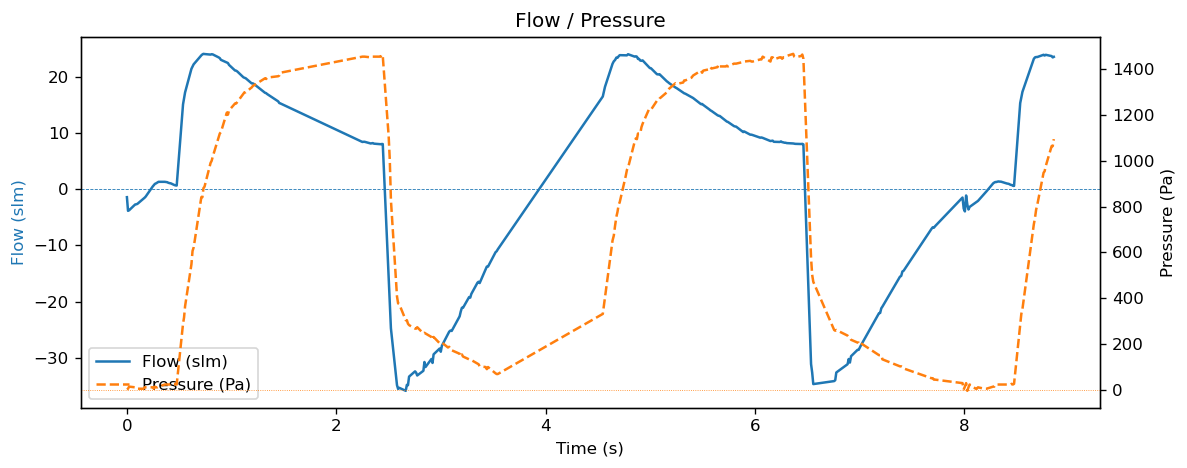

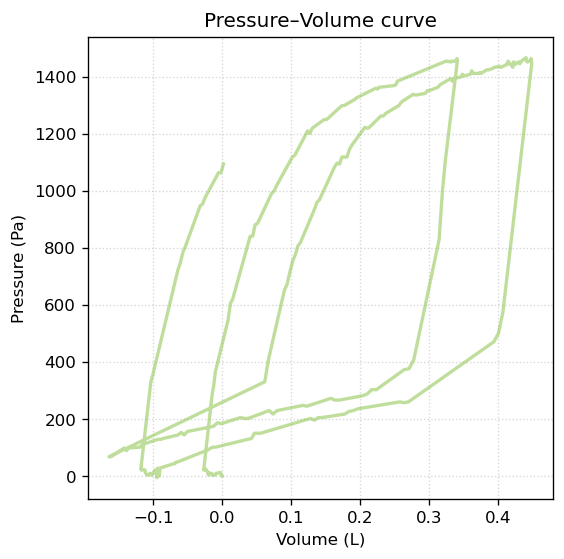

In [ ]:
# --- Configuration ---
# Use list_npz_files(...) to locate candidate segments, then paste a path below.
# npz_path = r'/home/oi/Multimodal-respiratory-sound-classification/data/MMDataset_segments/251130/2025-11-30_23-21-23-SFM3300AW_24400737.edf__record_20251130T161046Z.wav/record_20251130T161046Z.wav__2025-11-30_23-21-23-SFM3300AW_24400737.edf_win00000.npz'
npz_path = r'/home/oi/Multimodal-respiratory-sound-classification/data/MMDataset_segments/251130/2025-11-30_23-21-23-SFM3300AW_24400737.edf__record_20251130T161046Z.wav/record_20251130T161046Z.wav__2025-11-30_23-21-23-SFM3300AW_24400737.edf_win00036.npz'
# npz_path = r'/home/oi/Multimodal-respiratory-sound-classification/data/MMDataset_segments/251118/2025-11-18_00-36-39-SFM3300AW_24400737.edf__record_20251117T163755Z.wav/record_20251117T163755Z.wav__2025-11-18_00-36-39-SFM3300AW_24400737.edf_win00050.npz'
flow_col = "F_"
press_col = "P_"
time_col = "sensor_time_epoch"

# Window options (pick either UTC or index window)
start_utc = None
duration_sec = None
start_index = 0
num_samples = None

# --- Load, slice, and plot ---
df, flow_col, press_col, time_col, meta = load_npz_segment(
    npz_path,
    flow_col=flow_col,
    press_col=press_col,
    time_col=time_col,
)
print("Resolved columns -> flow:", flow_col, "pressure:", press_col, "time:", time_col)
print("Meta:", meta)

window = select_sensor_window(
    df,
    time_col=time_col,
    start_utc=start_utc,
    duration_sec=duration_sec,
    start_index=start_index,
    num_samples=num_samples,
)
print(f"Window has {len(window):,} samples")
if len(window) < 2:
    raise RuntimeError("Selected window is empty. Adjust the configuration above.")

relative_time_s, volume_l = compute_volume_from_flow(window, flow_col, time_col=time_col)
pressure = window[press_col].to_numpy(dtype=float)

plot_flow_and_pressure(window, relative_time_s, flow_col, press_col)
plot_pv_curve(volume_l, pressure)


In [ ]:
# --- P, Q, and corresponding mel spectrogram (separate columns) ---
import torch
import torchaudio

data = np.load(npz_path, allow_pickle=True)
if 'audio' not in data or 'audio_rate_hz' not in data:
    raise KeyError('Expected audio and audio_rate_hz in npz. Available keys: ' + ', '.join(data.files))

audio = data['audio'].astype(np.float32)
sr = int(np.asarray(data['audio_rate_hz']).item())

# Ensure mono audio (shape: [num_samples])
if audio.ndim == 2:
    # Handle (channels, samples) or (samples, channels)
    if audio.shape[0] <= audio.shape[1]:
        audio_mono = audio.mean(axis=0)
    else:
        audio_mono = audio.mean(axis=1)
else:
    audio_mono = audio

audio_tensor = torch.from_numpy(audio_mono).unsqueeze(0)

n_fft = 1024
hop_length = 256
n_mels = 64

mel_transform = torchaudio.transforms.MelSpectrogram(
    sample_rate=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels
)
db_transform = torchaudio.transforms.AmplitudeToDB(top_db=80)

mel_spec = mel_transform(audio_tensor)
mel_db = db_transform(mel_spec)[0].numpy()

fig, (ax_q, ax_p, ax_mel) = plt.subplots(1, 3, figsize=(14, 4))

ax_q.plot(relative_time_s, window[flow_col], color='tab:blue', linewidth=1.5)
ax_q.axhline(0.0, color='tab:blue', linestyle='--', linewidth=0.5)
ax_q.set_title('Flow (Q)')
ax_q.set_xlabel('Time (s)')
ax_q.set_ylabel('Flow (slm)')

ax_p.plot(relative_time_s, window[press_col], color='tab:orange', linewidth=1.5)
ax_p.axhline(0.0, color='tab:orange', linestyle='--', linewidth=0.5)
ax_p.set_title('Pressure (P)')
ax_p.set_xlabel('Time (s)')
ax_p.set_ylabel('Pressure (Pa)')

im = ax_mel.imshow(mel_db, origin='lower', aspect='auto', cmap='magma')
ax_mel.set_title('Mel Spectrogram')
ax_mel.set_xlabel('Frames')
ax_mel.set_ylabel('Mel bins')
fig.colorbar(im, ax=ax_mel, format='%+2.0f dB')

fig.tight_layout()
plt.show()


Processed 59 files under: ../data/MMDataset_segments/251118/2025-11-17_23-44-27-SFM3300AW_24410080.edf__record_20251117T154541Z.wav
Unique labels: ['no secretion']
All labels identical.


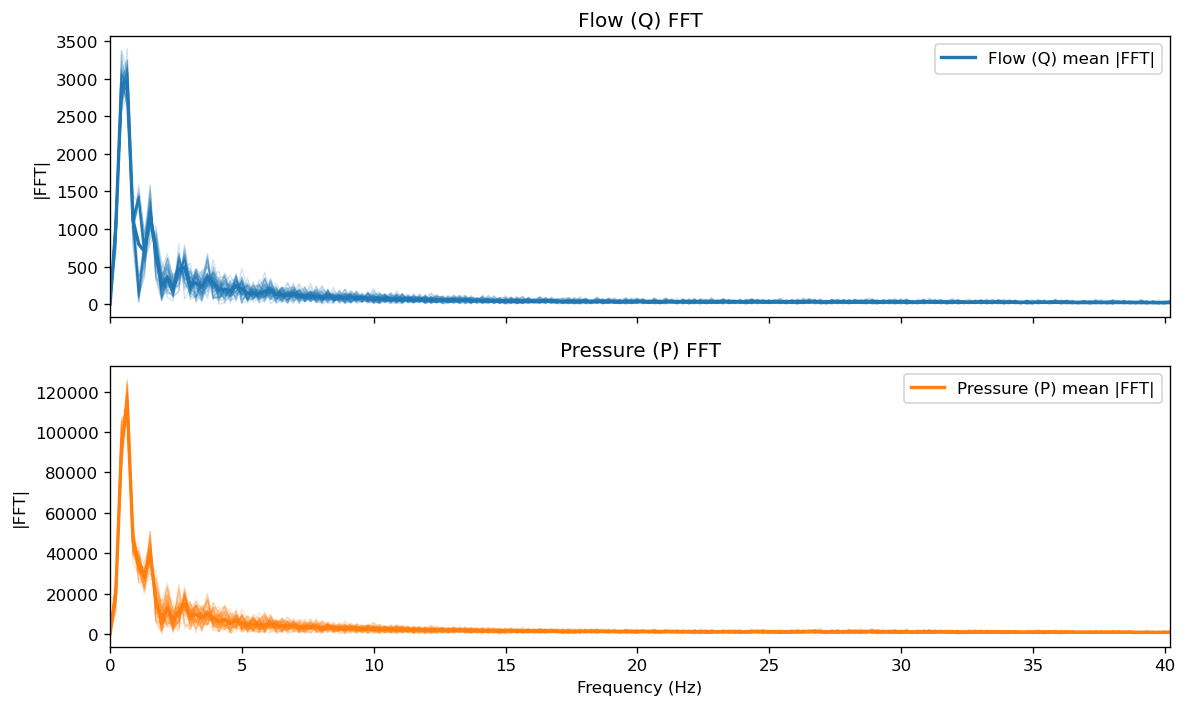

Processed 59 files under: ../data/MMDataset_segments/251118/2025-11-18_00-36-39-SFM3300AW_24400737.edf__record_20251117T163755Z.wav
Unique labels: ['3mL secretion']
All labels identical.


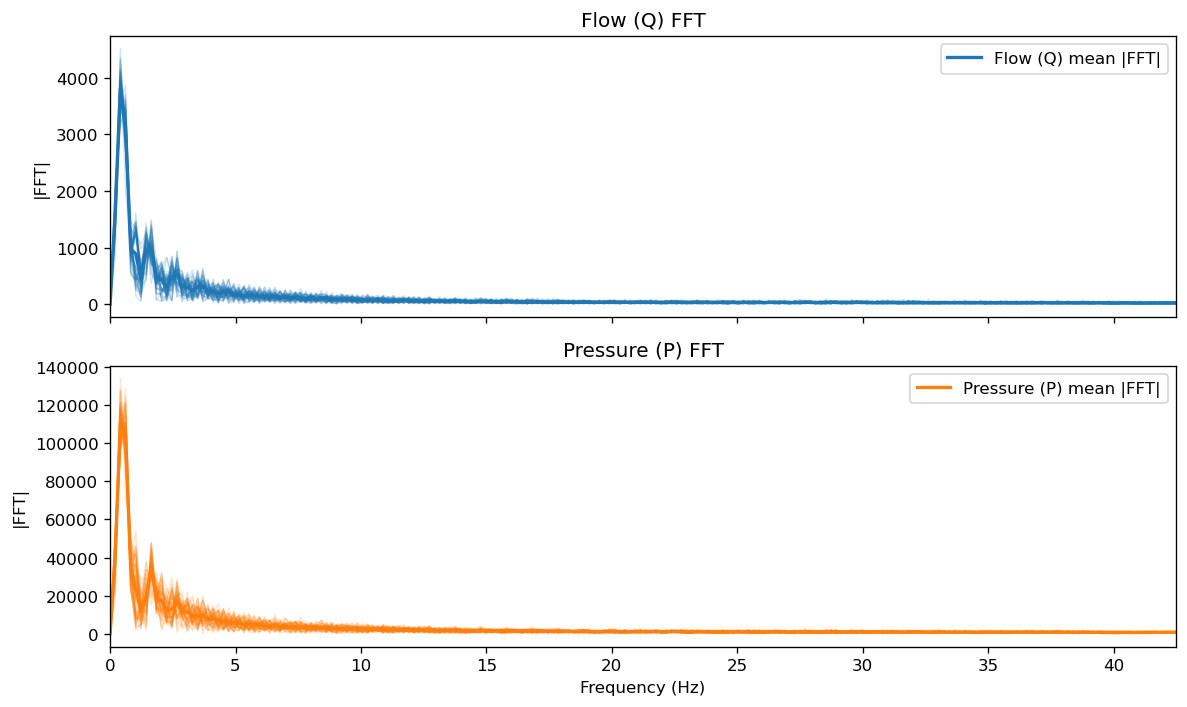

In [ ]:
# --- FFT over a directory; P & Q on separate subplots ---

def visualize_dir_fft(segments_dir: str, flow_hint: str = 'F_', press_hint: str = 'P_') -> None:
    npz_files = sorted(glob.glob(os.path.join(segments_dir, '**', '*.npz'), recursive=True))
    if not npz_files:
        raise RuntimeError(f"No .npz files found under: {segments_dir}")

    def _pick_column(cols, hint: str) -> str:
        for c in cols:
            if c.startswith(hint):
                return c
        for c in cols:
            if hint.lower() in c.lower():
                return c
        return cols[0]

    def calc_fft(series: np.ndarray, fs: float):
        centered = series - np.mean(series)
        spec = np.fft.rfft(centered)
        freqs = np.fft.rfftfreq(len(series), d=1.0 / fs)
        return freqs, np.abs(spec)

    labels: list[str] = []
    flow_mags: list[np.ndarray] = []
    press_mags: list[np.ndarray] = []
    freq_axis = None

    for npz_path in npz_files:
        data = np.load(npz_path, allow_pickle=True)
        labels.append(str(_scalar_value(data.get('label', ''))))

        sensor_cols = [str(c) for c in data['sensor_cols']]
        df = pd.DataFrame(data['sensor_values'], columns=sensor_cols)
        flow_col = _pick_column(sensor_cols, flow_hint)
        press_col = _pick_column(sensor_cols, press_hint)

        time_vals = data['sensor_time_epoch'].astype(float)
        dt = float(np.median(np.diff(time_vals)))
        if dt <= 0:
            raise RuntimeError(f'Non-positive dt found in {npz_path}')
        fs = 1.0 / dt

        freq_flow, mag_flow = calc_fft(df[flow_col].to_numpy(dtype=float), fs)
        freq_press, mag_press = calc_fft(df[press_col].to_numpy(dtype=float), fs)

        if freq_axis is None:
            freq_axis = freq_flow
        else:
            min_len = min(len(freq_axis), len(freq_flow), len(freq_press))
            freq_axis = freq_axis[:min_len]
            flow_mags = [m[:min_len] for m in flow_mags]
            press_mags = [m[:min_len] for m in press_mags]
            mag_flow = mag_flow[:min_len]
            mag_press = mag_press[:min_len]

        flow_mags.append(mag_flow)
        press_mags.append(mag_press)

    unique_labels = sorted(set(labels))
    print(f'Processed {len(npz_files)} files under: {segments_dir}')
    print('Unique labels:', unique_labels)
    if len(unique_labels) == 1:
        print('All labels identical.')

    if freq_axis is None:
        print('No FFT data to plot.')
        return

    flow_mean = np.vstack(flow_mags).mean(axis=0)
    press_mean = np.vstack(press_mags).mean(axis=0)

    fig, (ax_flow, ax_press) = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
    for mag in flow_mags:
        ax_flow.plot(freq_axis, mag, color='tab:blue', alpha=0.2, linewidth=0.8)
    ax_flow.plot(freq_axis, flow_mean, color='tab:blue', linewidth=2.0, label='Flow (Q) mean |FFT|')
    ax_flow.set_ylabel('|FFT|')
    ax_flow.set_title('Flow (Q) FFT')
    ax_flow.legend()

    for mag in press_mags:
        ax_press.plot(freq_axis, mag, color='tab:orange', alpha=0.2, linewidth=0.8)
    ax_press.plot(freq_axis, press_mean, color='tab:orange', linewidth=2.0, label='Pressure (P) mean |FFT|')
    ax_press.set_xlim(0, freq_axis.max())
    ax_press.set_xlabel('Frequency (Hz)')
    ax_press.set_ylabel('|FFT|')
    ax_press.set_title('Pressure (P) FFT')
    ax_press.legend()

    fig.tight_layout()
    plt.show()


# Example: uncomment and update the directory to run
visualize_dir_fft(r'../data/MMDataset_segments/251118/2025-11-17_23-44-27-SFM3300AW_24410080.edf__record_20251117T154541Z.wav')
visualize_dir_fft(r'../data/MMDataset_segments/251118/2025-11-18_00-36-39-SFM3300AW_24400737.edf__record_20251117T163755Z.wav')


